# Title: Cardiovascular Disease Prediction Using Deep Learning

#### Group Member Names : Sima Masoumi




### Context

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Data Dictionary:
    age: age in years
    sex: sex (1 = male; 0 = female)
    cp: chest pain type
    -- Value 0: typical angina
    -- Value 1: atypical angina
    -- Value 2: non-anginal pain
    -- Value 3: asymptomatic
    trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    chol: serum cholestoral in mg/dl
    fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    restecg: resting electrocardiographic results
    -- Value 0: normal
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
    thalach: maximum heart rate achieved
    exang: exercise induced angina (1 = yes; 0 = no)
    oldpeak = ST depression induced by exercise relative to rest
    slope: the slope of the peak exercise ST segment
    -- Value 0: upsloping
    -- Value 1: flat
    -- Value 2: downsloping
    ca: number of major vessels (0-3) colored by flourosopy
    thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
    and the label
    condition: 0 = no disease, 1 = disease


# Library Imports

In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np


from sklearn.preprocessing import LabelEncoder

# Loading the data:

In [2]:
df = pd.read_csv('/content/heart.csv')
df = df.drop(columns=['ca', 'thal'])
print(df.shape)

(1025, 12)


In [3]:
# Mapping dictionaries for each feature
sex_mapping = {1: 'male', 0: 'female'}
cp_mapping = {0: 'typical angina', 1: 'atypical angina', 2: 'non-anginal', 3: 'asymptomatic'}
fbs_mapping = {1: True, 0: False}
restecg_mapping = {0: 'normal', 1: 'st-t abnormality', 2: 'lv hypertrophy'}
slope_mapping = {0: 'upsloping', 1: 'flat', 2: 'downsloping'}


# Replace numerical values with their corresponding categories
df['sex'] = df['sex'].map(sex_mapping)
df['cp'] = df['cp'].map(cp_mapping)
df['fbs'] = df['fbs'].map(fbs_mapping)
df['restecg'] = df['restecg'].map(restecg_mapping)
df['slope'] = df['slope'].map(slope_mapping)


df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,52,male,typical angina,125,212,False,st-t abnormality,168,0,1.0,downsloping,0
1,53,male,typical angina,140,203,True,normal,155,1,3.1,upsloping,0
2,70,male,typical angina,145,174,False,st-t abnormality,125,1,2.6,upsloping,0
3,61,male,typical angina,148,203,False,st-t abnormality,161,0,0.0,downsloping,0
4,62,female,typical angina,138,294,True,st-t abnormality,106,0,1.9,flat,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   object 
 2   cp        1025 non-null   object 
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   bool   
 6   restecg   1025 non-null   object 
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   object 
 11  target    1025 non-null   int64  
dtypes: bool(1), float64(1), int64(6), object(4)
memory usage: 89.2+ KB


In [5]:
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,52,male,typical angina,125,212,False,st-t abnormality,168,0,1.0,downsloping,0
1,53,male,typical angina,140,203,True,normal,155,1,3.1,upsloping,0


In [6]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
target      0
dtype: int64

# Exploratory Data Analysis

### Some functions to use for EDA

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    plt.show()


# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,52,male,typical angina,125,212,False,st-t abnormality,168,0,1.0,downsloping,0
1,53,male,typical angina,140,203,True,normal,155,1,3.1,upsloping,0
2,70,male,typical angina,145,174,False,st-t abnormality,125,1,2.6,upsloping,0
3,61,male,typical angina,148,203,False,st-t abnormality,161,0,0.0,downsloping,0
4,62,female,typical angina,138,294,True,st-t abnormality,106,0,1.9,flat,0


## Univariate analysis

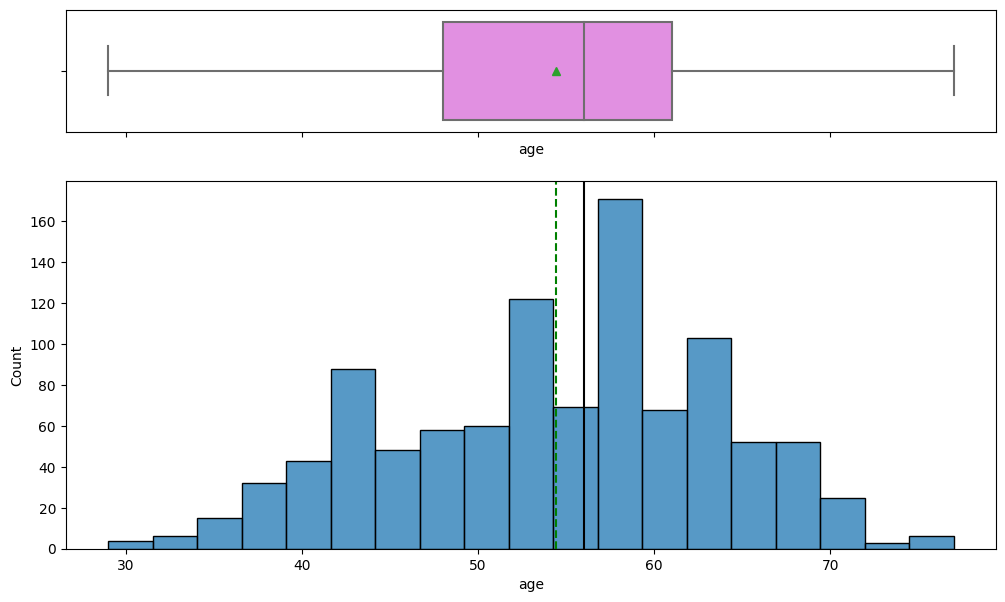

In [50]:
histogram_boxplot(df, 'age')

**The age of the patients follows a close to normal distribution with no outliers**

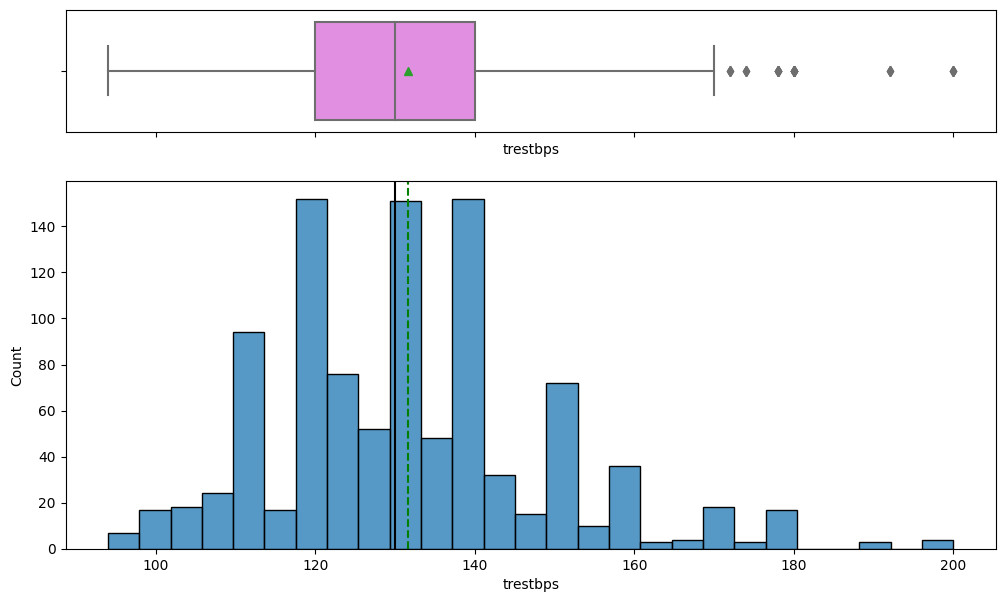

In [51]:
histogram_boxplot(df, 'trestbps')

A few outliers are present in the trestbps feature, and the distribution is slightly skewed to the right side

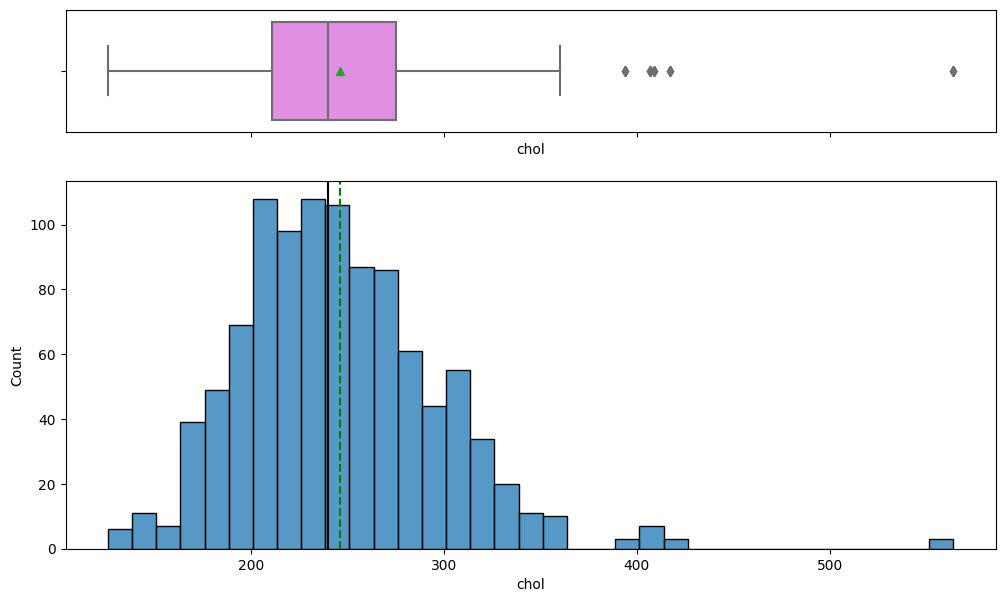

In [52]:
histogram_boxplot(df, 'chol')

Outliers are present in the chol features.

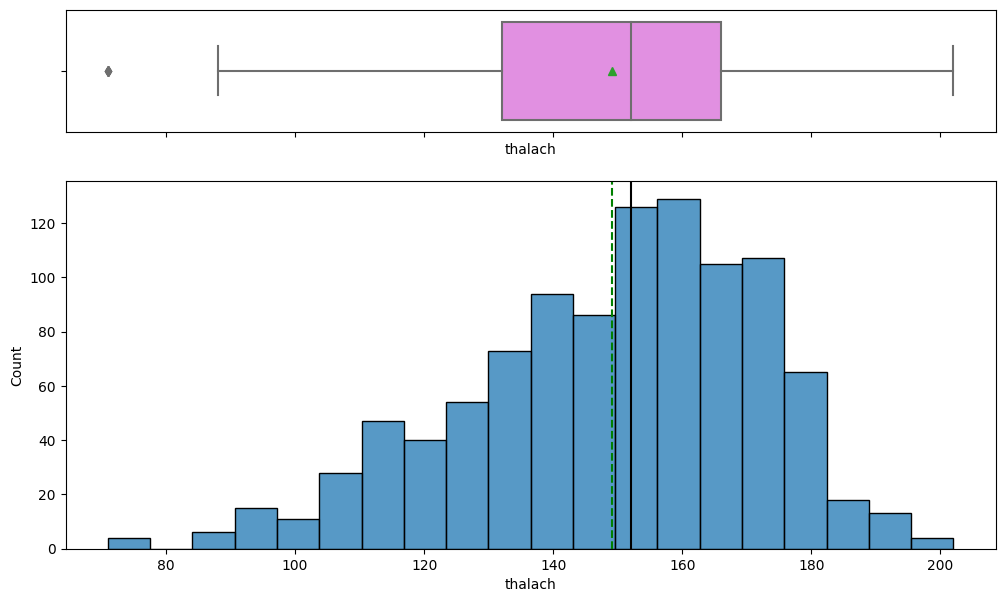

In [53]:
histogram_boxplot(df, 'thalach')

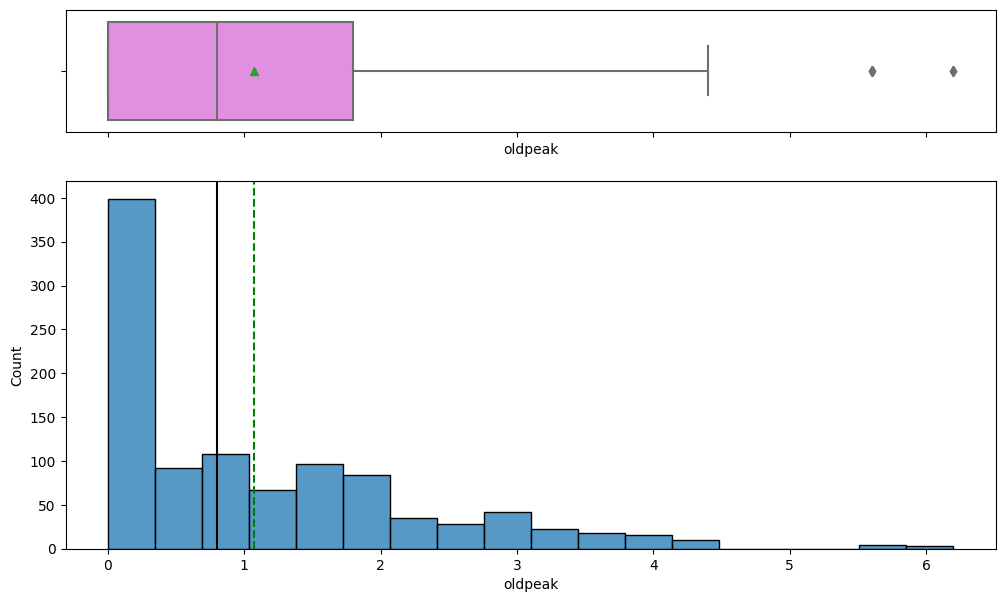

In [54]:
histogram_boxplot(df, 'oldpeak')

The features oldpeak is skewed to the right side

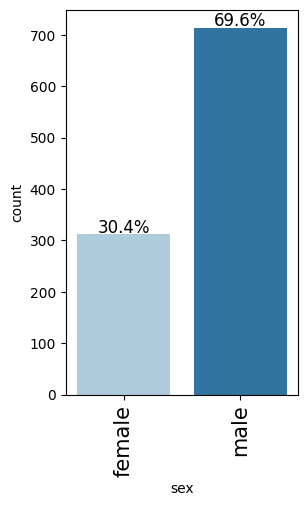

In [61]:
labeled_barplot(df, "sex", perc=True)

70% of the patients in this study are males and 30% females

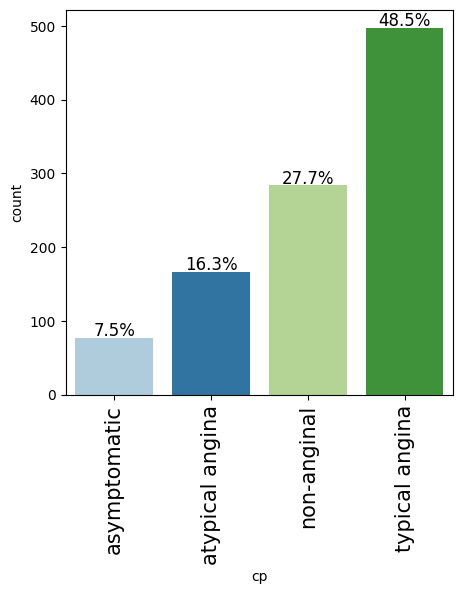

In [62]:
labeled_barplot(df, "cp", perc=True)

**Typical angina is the most common chest pain type, with 48.5 percent and there are 7.5 percent asymptomatic**

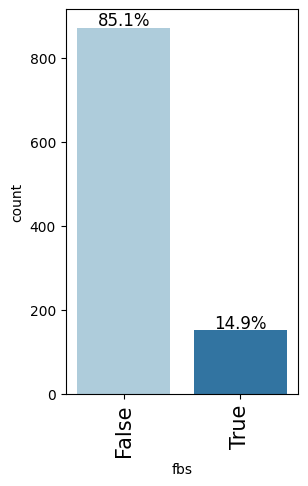

In [63]:
labeled_barplot(df, "fbs", perc=True)

There is only 15 percent of the patients with fasting blood sugar > 120 mg/dl

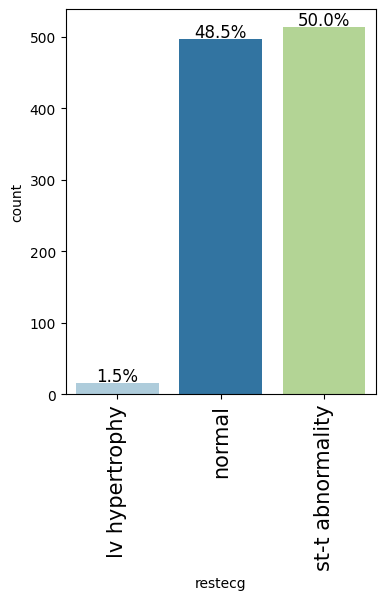

In [64]:
labeled_barplot(df, "restecg", perc=True)

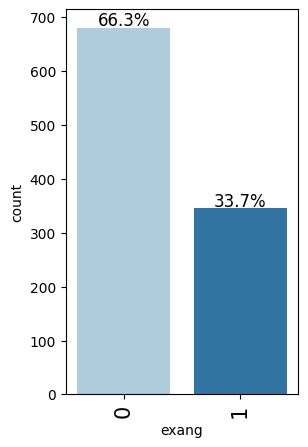

In [65]:
labeled_barplot(df, "exang", perc=True)

33.7 percent have exercise induced angina

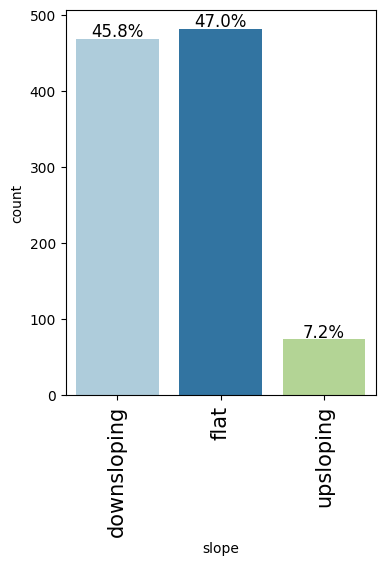

In [66]:
labeled_barplot(df, "slope", perc=True)

There is only 7.2 percent that are upsloping

### Multivariate analysis

target    0    1   All
sex                   
All     499  526  1025
male    413  300   713
female   86  226   312
------------------------------------------------------------------------------------------------------------------------


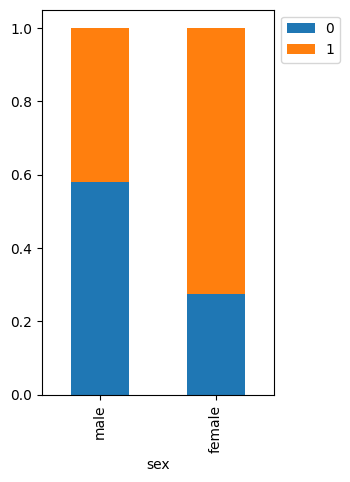

In [9]:
stacked_barplot(df, "sex", "target")

The chart above shows that the heart disease in women is much more common than the men (almost double)

target    0    1   All
fbs                   
All     499  526  1025
False   417  455   872
True     82   71   153
------------------------------------------------------------------------------------------------------------------------


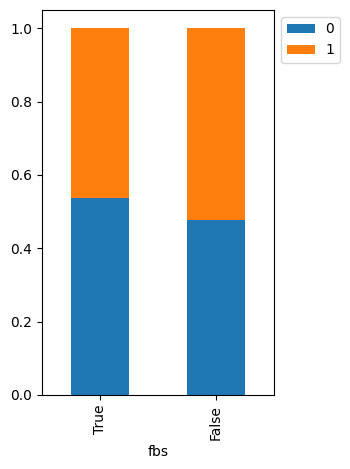

In [10]:
stacked_barplot(df, "fbs", "target")

IT seems like fasting blood sugar > 120 mg/dl does not have a direct impact on heart disease.

target              0    1   All
restecg                         
All               499  526  1025
normal            283  214   497
st-t abnormality  204  309   513
lv hypertrophy     12    3    15
------------------------------------------------------------------------------------------------------------------------


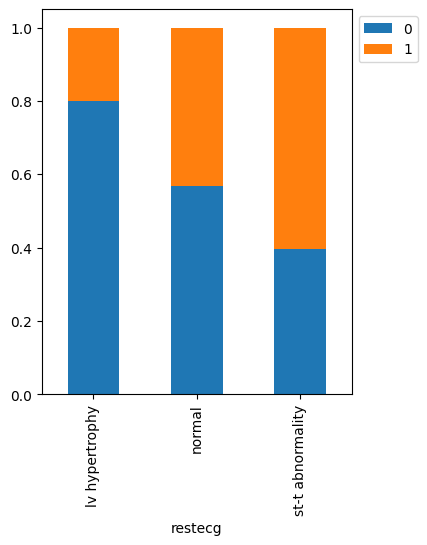

In [11]:
stacked_barplot(df, "restecg", "target")

Patients with resting electrocardiographic results being ST-S Abnormality have the highest rate of heart disease, about 60 percent of them had a heart disease

target         0    1   All
slope                      
All          499  526  1025
flat         324  158   482
downsloping  129  340   469
upsloping     46   28    74
------------------------------------------------------------------------------------------------------------------------


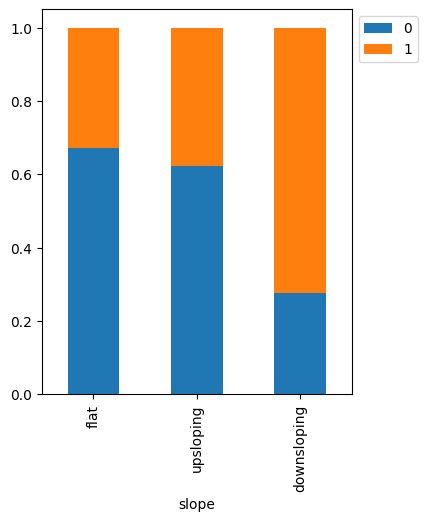

In [12]:
stacked_barplot(df, "slope", "target")

PAtients with downsloping have the highest rate of heart disease, around 75 percent.

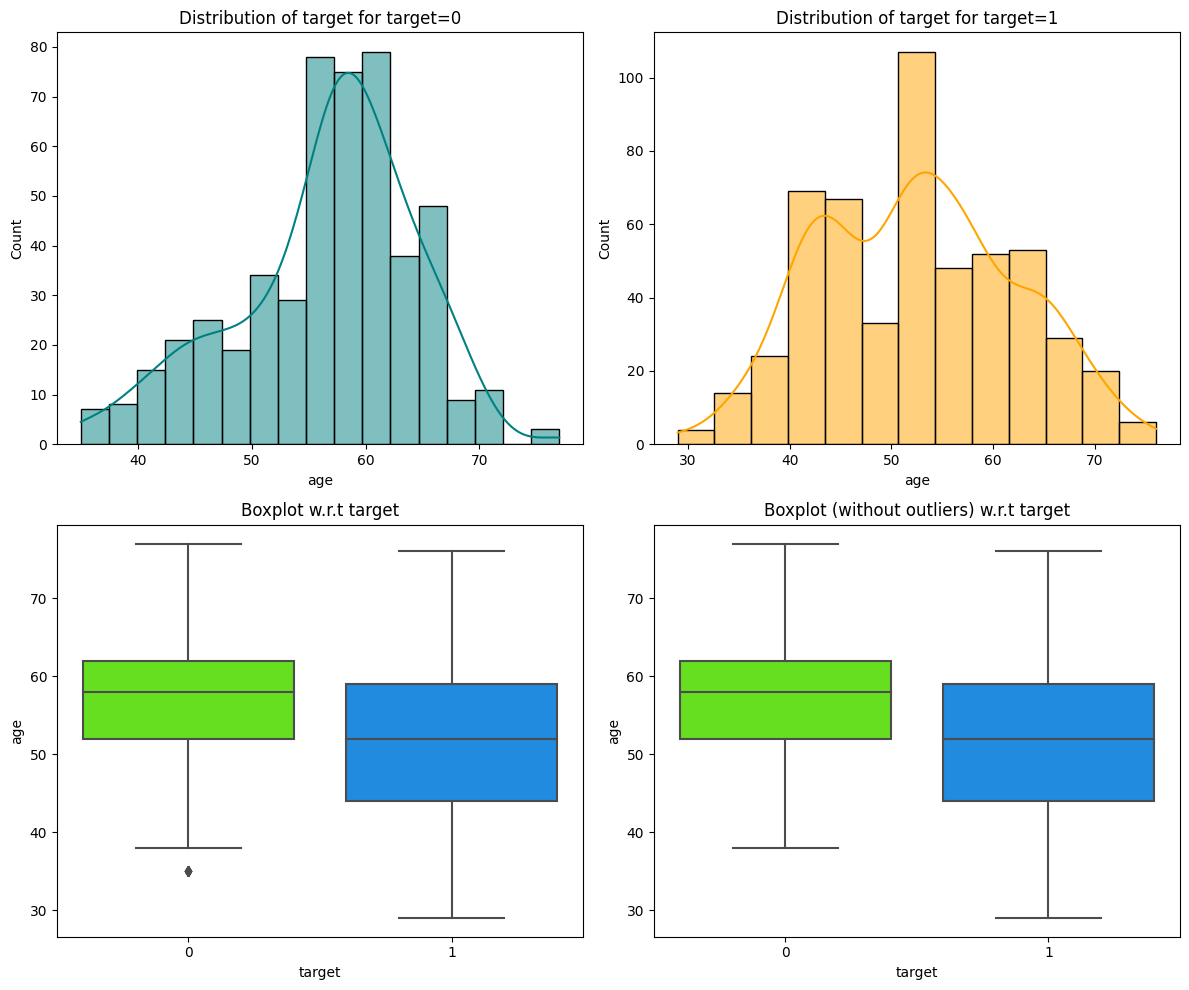

In [15]:
distribution_plot_wrt_target(df, "age", "target")

With the data we have in hand, it seems like the patients suffering from heart disease tend to be younger

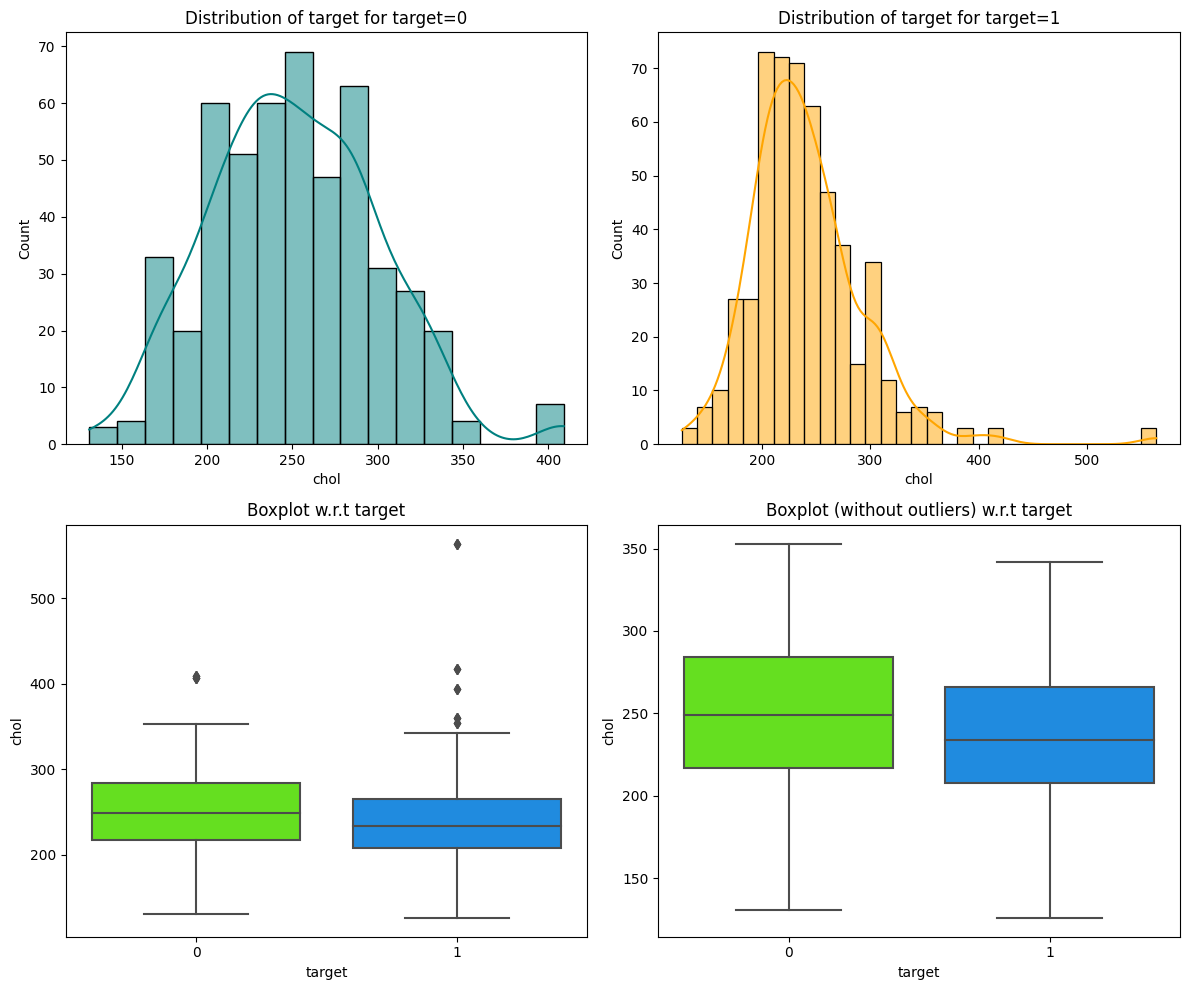

In [16]:
distribution_plot_wrt_target(df, "chol", "target")

Patients with heart disease tend to have lower cholesterol level

# Data Preprocessing and Model Building

In [8]:
X = df.drop(columns=['target'])
y = df['target']

In [9]:
# Columns to one-hot encode
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'  # Keep the non-categorical columns as they are
)

# Apply the transformation
X = preprocessor.fit_transform(X)


In [10]:
X

array([[  1. ,   0. ,   0. , ..., 212. , 168. ,   1. ],
       [  1. ,   0. ,   0. , ..., 203. , 155. ,   3.1],
       [  1. ,   0. ,   0. , ..., 174. , 125. ,   2.6],
       ...,
       [  1. ,   0. ,   0. , ..., 275. , 118. ,   1. ],
       [  0. ,   0. ,   0. , ..., 254. , 159. ,   0. ],
       [  1. ,   0. ,   0. , ..., 188. , 113. ,   1.4]])

In [11]:
X.shape

(1025, 15)

#### Divide the data set into Train and test sets



In [12]:
# Splitting the dataset into the Training and Testing set.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [13]:
X_train.shape

(820, 15)

#### Normalize the train and test data

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
X_train.shape

(820, 15)

#### Initialize & build the model

In [16]:
classifier = Sequential()

classifier.add(Dense(activation = 'relu', input_dim = 15, units=64))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

classifier.compile(optimizer='SGD', loss='mse', metrics=[tf.keras.metrics.Recall()])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [17]:
history=classifier.fit(X_train, y_train,
          validation_split=0.2,
          epochs=200,
          batch_size=32)

Epoch 1/200
21/21 [==============================] - 1s 15ms/step - loss: 0.2494 - recall: 0.6380 - val_loss: 0.2465 - val_recall: 0.6744
Epoch 2/200
21/21 [==============================] - 0s 4ms/step - loss: 0.2381 - recall: 0.6795 - val_loss: 0.2390 - val_recall: 0.6628
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 0.2280 - recall: 0.7181 - val_loss: 0.2323 - val_recall: 0.6744
Epoch 4/200
21/21 [==============================] - 0s 4ms/step - loss: 0.2189 - recall: 0.7329 - val_loss: 0.2264 - val_recall: 0.7326
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 0.2110 - recall: 0.7537 - val_loss: 0.2210 - val_recall: 0.7442
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.2039 - recall: 0.7626 - val_loss: 0.2161 - val_recall: 0.7442
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 0.1974 - recall: 0.7834 - val_loss: 0.2116 - val_recall: 0.7558
Epoch 8/200
21/21 [=====================

7/7 [==============================] - 0s 8ms/step - loss: 0.1367 - accuracy: 0.7756


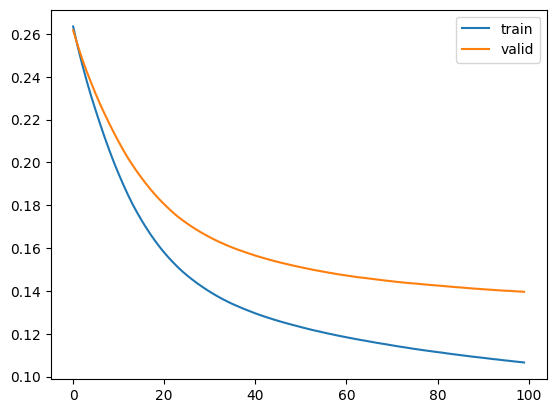

In [ ]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = classifier.evaluate(X_test, y_test)

In [ ]:

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

7/7 [==============================] - 0s 4ms/step


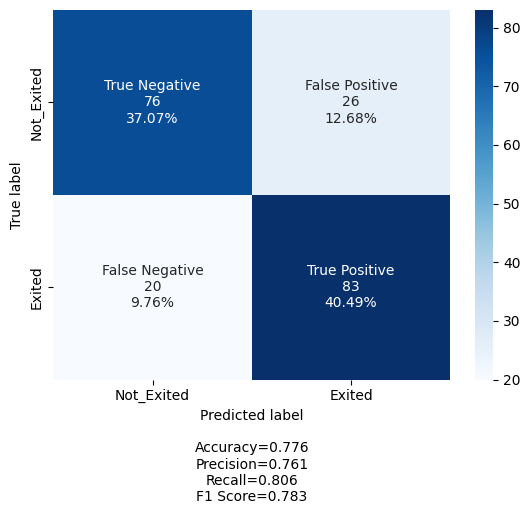

In [ ]:
#Calculating the confusion matrix
y_pred1=classifier.predict(X_test)

#Let's predict using default threshold
y_pred1 = (y_pred1 > 0.5)
cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [ ]:
def create_model():
          #Initializing the neural network
          model = Sequential()
          #Adding the hidden and output layers
          model.add(Dense(64,activation='relu',input_dim = X_train.shape[1]))
          model.add(Dense(32,activation='relu'))
          model.add(Dense(1, activation = 'sigmoid'))
          #Compiling the ANN with RMSprop optimizer and binary cross entropy loss function
          optimizer = tf.keras.optimizers.Adam(0.001)
          model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
          return model

In [ ]:
model=create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1024      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the ANN with batch_size = 32 and 100 epochs
history = model.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_split = 0.2)

Epoch 1/100
21/21 [==============================] - 3s 24ms/step - loss: 0.7622 - accuracy: 0.5000 - val_loss: 0.6562 - val_accuracy: 0.6098
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 0.5642 - accuracy: 0.7500 - val_loss: 0.5502 - val_accuracy: 0.7561
Epoch 3/100
21/21 [==============================] - 0s 8ms/step - loss: 0.4597 - accuracy: 0.8186 - val_loss: 0.4859 - val_accuracy: 0.7988
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 0.4101 - accuracy: 0.8171 - val_loss: 0.4541 - val_accuracy: 0.8171
Epoch 5/100
21/21 [==============================] - 0s 9ms/step - loss: 0.3828 - accuracy: 0.8277 - val_loss: 0.4353 - val_accuracy: 0.8232
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 0.3630 - accuracy: 0.8506 - val_loss: 0.4241 - val_accuracy: 0.8232
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.3479 - accuracy: 0.8476 - val_loss: 0.4115 - val_accuracy: 0.8293
Epoch 8/100

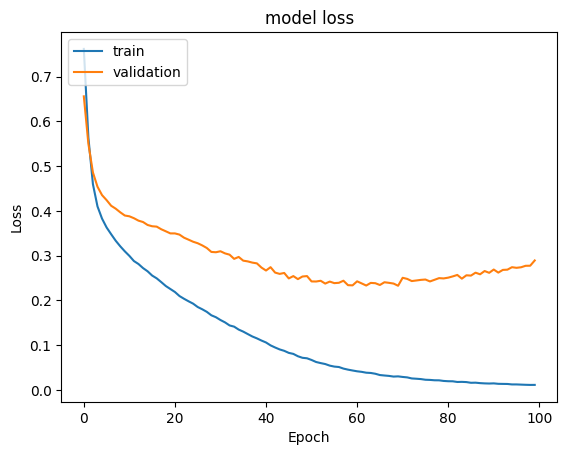

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


As you can see from the above image, this model is severely overfitting. Deep learning models are very senstive to overfititng due to large amount of parameters. We need to find the optimal point where the training should be stopped.

The best solution for the above problem is **Early stopping**.

**Early stopping:**

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

In [ ]:
#Importing classback API
from keras import callbacks
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
model_e=create_model()
#Fitting the ANN with batch_size = 32 and 100 epochs
history_e = model_e.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_split = 0.2,callbacks=[es_cb])

Epoch 1/100
21/21 [==============================] - 2s 23ms/step - loss: 0.5477 - accuracy: 0.7576 - val_loss: 0.5187 - val_accuracy: 0.7256
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 0.4296 - accuracy: 0.8155 - val_loss: 0.4638 - val_accuracy: 0.7439
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 0.3834 - accuracy: 0.8308 - val_loss: 0.4382 - val_accuracy: 0.7927
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 0.3563 - accuracy: 0.8369 - val_loss: 0.4255 - val_accuracy: 0.7805
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 0.3387 - accuracy: 0.8476 - val_loss: 0.4161 - val_accuracy: 0.8049
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 0.3227 - accuracy: 0.8537 - val_loss: 0.4020 - val_accuracy: 0.8354
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 0.3101 - accuracy: 0.8704 - val_loss: 0.3892 - val_accuracy: 0.8537
Epoch 8/

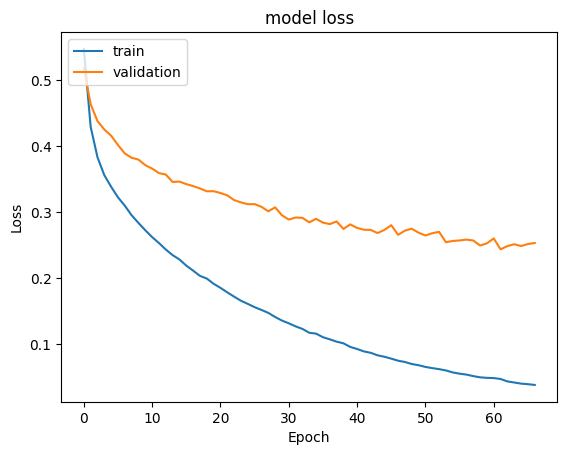

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_e.history['loss'])
plt.plot(history_e.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


**Let's tune the threshold using ROC-AUC**


There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

Sensitivity = TruePositive / (TruePositive + FalseNegative)


Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:

Sensitivity = True Positive Rate

Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)

One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

7/7 [==============================] - 0s 6ms/step
Best Threshold=0.213943, G-Mean=0.976


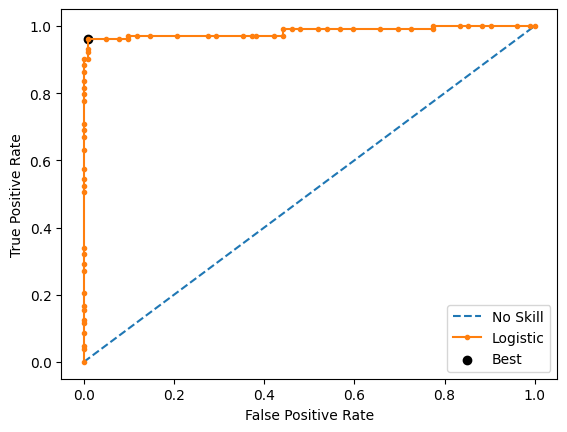

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat = model.predict(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Predicting the results using best as a threshold
y_pred_e=model_e.predict(X_test)
y_pred_e = (y_pred_e > thresholds[ix])
y_pred_e

7/7 [==============================] - 0s 3ms/step


array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [

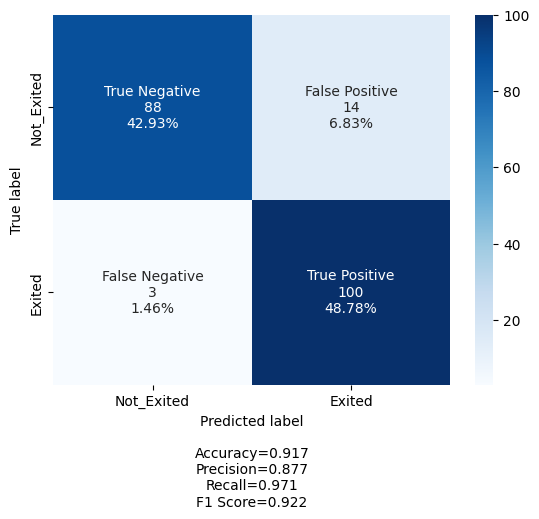

In [ ]:
#Calculating the confusion matrix

cm1=confusion_matrix(y_test, y_pred_e)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

#Conclusion:
### Some of the factors contributing heart disease:
1. Patients with heart disease tend to have lower cholesterol level
2. With the data we have in hand, it seems like the patients suffering from heart disease tend to be younger<br>
Patients with downsloping have the highest rate of heart disease, around 75 percent.<br>
3. Patients with resting electrocardiographic results being ST-S Abnormality have the highest rate of heart disease, about 60 percent of them had a heart disease<br>
4. IT seems like fasting blood sugar > 120 mg/dl does not have a direct impact on heart disease.

### Model performance:
The deep learning model has a recall score of 97 percent on the test data
